In [2]:
# ================================================================
# 1: Import Libraries
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import time

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette([ "#1f4e79" ])   # a strong, navy‑blue

print("📚 Libraries imported successfully!")

📚 Libraries imported successfully!


In [3]:
# ================================================================
# 2. LOAD SAVED DATA
# ================================================================
print("📂 Loading saved training and test data...")
print("=" * 50)

try:
    # Load features
    X_train_knn = pd.read_csv('../Data/output/X_train_encoded.csv')
    X_test_knn = pd.read_csv('../Data/output/X_test_encoded.csv')
    
    # Load labels
    y_train_knn = pd.read_csv('../Data/output/y_train.csv').squeeze()  # squeeze() converts DataFrame to Series
    y_test_knn = pd.read_csv('../Data/output/y_test.csv').squeeze()
    
    print("✅ Data loaded successfully!")
    print(f"   Training features: {X_train_knn.shape}")
    print(f"   Test features: {X_test_knn.shape}")
    print(f"   Training labels: {y_train_knn.shape}")
    print(f"   Test labels: {y_test_knn.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error: Could not find data files. {e}")
    print("Make sure you've run the encoding notebook first!")
except Exception as e:
    print(f"❌ Error loading data: {e}")

📂 Loading saved training and test data...
✅ Data loaded successfully!
   Training features: (22180, 20)
   Test features: (5545, 20)
   Training labels: (22180,)
   Test labels: (5545,)


In [4]:
# ================================================================
# 3. ANALYZE CLASS DISTRIBUTION (DETERMINES BEST SCORING METRIC)
# ================================================================

print("📊 ANALYZING CLASS DISTRIBUTION")
print("=" * 50)

# Check target variable distribution using your training data
class_counts = pd.Series(y_train_knn).value_counts().sort_index()
class_percentages = pd.Series(y_train_knn).value_counts(normalize=True).sort_index() * 100

print("Class distribution in training data:")
for class_label, count in class_counts.items():
    percentage = class_percentages[class_label]
    print(f"  Class {class_label}: {count:,} samples ({percentage:.1f}%)")

# Calculate imbalance ratio
max_class_count = class_counts.max()
min_class_count = class_counts.min()
imbalance_ratio = max_class_count / min_class_count

print(f"\n📈 Imbalance Analysis:")
print(f"  Largest class: {max_class_count:,} samples")
print(f"  Smallest class: {min_class_count:,} samples")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# Determine best scoring metric
if imbalance_ratio > 2.0:
    print("⚠️  Dataset appears imbalanced - F1-weighted recommended")
    recommended_scoring = 'f1_weighted'
    scoring_explanation = "F1-weighted handles class imbalance better than accuracy"
else:
    print("✅ Dataset appears balanced - accuracy is acceptable")
    recommended_scoring = 'accuracy'
    scoring_explanation = "Accuracy is reliable for balanced datasets"

print(f"🎯 Recommended scoring: {recommended_scoring}")
print(f"💡 Why: {scoring_explanation}")


📊 ANALYZING CLASS DISTRIBUTION
Class distribution in training data:
  Class 0: 4,237 samples (19.1%)
  Class 1: 5,634 samples (25.4%)
  Class 2: 12,309 samples (55.5%)

📈 Imbalance Analysis:
  Largest class: 12,309 samples
  Smallest class: 4,237 samples
  Imbalance ratio: 2.91:1
⚠️  Dataset appears imbalanced - F1-weighted recommended
🎯 Recommended scoring: f1_weighted
💡 Why: F1-weighted handles class imbalance better than accuracy


In [5]:
# ================================================================
# 4. FEATURE SCALING FOR KNN (IMPORTANT STEP)
# ================================================================

print(f"\n🔧 FEATURE SCALING FOR KNN")
print("=" * 50)
print("⚡ KNN is distance-based - feature scaling is CRITICAL!")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler on training data and transform both train and test
X_train_knn_scaled = scaler.fit_transform(X_train_knn)
X_test_knn_scaled = scaler.transform(X_test_knn)

print("✅ Feature scaling completed!")
print(f"   Original feature range example: {X_train_knn.iloc[:, 0].min():.2f} to {X_train_knn.iloc[:, 0].max():.2f}")
print(f"   Scaled feature range example: {X_train_knn_scaled[:, 0].min():.2f} to {X_train_knn_scaled[:, 0].max():.2f}")
print("📊 All features now have mean=0 and std=1")



🔧 FEATURE SCALING FOR KNN
⚡ KNN is distance-based - feature scaling is CRITICAL!
✅ Feature scaling completed!
   Original feature range example: 0.00 to 1.00
   Scaled feature range example: -1.23 to 0.81
📊 All features now have mean=0 and std=1


In [ ]:
# ================================================================
# 5. DEFINE PARAMETER GRIDS (CHOOSE YOUR SPEED VS THOROUGHNESS)
# ================================================================

print(f"\n🔧 PARAMETER GRID OPTIONS")
print("=" * 50)

# Option 1: FAST Grid (5-10 minutes)
fast_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Option 2: COMPREHENSIVE Grid (20-30 minutes)
comprehensive_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2],  # Only used when metric='minkowski'
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Option 3: SMART Grid (10-15 minutes) - RECOMMENDED
smart_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree']
}

# Choose which grid to use (CHANGE THIS IF YOU WANT DIFFERENT SPEED)
#chosen_param_grid = smart_param_grid  # RECOMMENDED
#grid_name = "SMART"
chosen_param_grid = comprehensive_param_grid
grid_name = "COMPREHENSIVE"

# Calculate combinations (approximation for complex grids)
if 'p' in chosen_param_grid:
    # Complex calculation for minkowski with p parameter
    base_combinations = 1
    for key, values in chosen_param_grid.items():
        if key != 'p':
            base_combinations *= len(values)
    # p parameter only applies when metric='minkowski'
    minkowski_count = chosen_param_grid.get('metric', []).count('minkowski') if 'minkowski' in chosen_param_grid.get('metric', []) else 0
    total_combinations = base_combinations + (minkowski_count * len(chosen_param_grid.get('p', [])))
else:
    total_combinations = np.prod([len(v) for v in chosen_param_grid.values()])

print(f"🎯 Using {grid_name} parameter grid")
print(f"📊 Approximate combinations to test: {total_combinations}")

if grid_name == "FAST":
    print("⏱️  Estimated time: 1-2 minutes")
elif grid_name == "SMART":
    print("⏱️  Estimated time: 10-15 minutes")
else:
    print("⏱️  Estimated time: 20-30 minutes")

print(f"\n💡 KNN Parameter Explanation:")
print(f"   • n_neighbors: Number of nearest neighbors to consider")
print(f"   • weights: How to weight neighbors ('uniform' or 'distance')")
print(f"   • metric: Distance calculation method")
print(f"   • algorithm: Algorithm used to compute nearest neighbors")


🔧 PARAMETER GRID OPTIONS
🎯 Using COMPREHENSIVE parameter grid
📊 Approximate combinations to test: 242
⏱️  Estimated time: 20-30 minutes

💡 KNN Parameter Explanation:
   • n_neighbors: Number of nearest neighbors to consider
   • weights: How to weight neighbors ('uniform' or 'distance')
   • metric: Distance calculation method
   • algorithm: Algorithm used to compute nearest neighbors


In [13]:
# ================================================================
# 6. SETUP MULTI-SCORING GRIDSEARCHCV
# ================================================================

print(f"\n🎯 GRIDSEARCHCV CONFIGURATION")
print("=" * 50)

# Define multiple scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted'
}

cv_folds = 5
print(f"🎯 Primary scoring metric: {recommended_scoring}")
print(f"📊 Additional metrics tracked: {list(scoring_metrics.keys())}")
print(f"🔄 Cross-validation folds: {cv_folds}")
print(f"💻 Parallel processing: Enabled (n_jobs=-1)")

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=chosen_param_grid,
    scoring=scoring_metrics,
    refit=recommended_scoring,  # Refit using the best metric for your data
    cv=cv_folds,               # n-fold CV (standard for KNN)
    n_jobs=-1,                 # Use all CPU cores
    verbose=2,                 # Show detailed progress
    return_train_score=True    # Track overfitting
)



🎯 GRIDSEARCHCV CONFIGURATION
🎯 Primary scoring metric: f1_weighted
📊 Additional metrics tracked: ['accuracy', 'f1_weighted', 'f1_macro', 'precision_weighted', 'recall_weighted']
🔄 Cross-validation folds: 5
💻 Parallel processing: Enabled (n_jobs=-1)


In [14]:
# ================================================================
# 7. RUN GRIDSEARCHCV
# ================================================================

print(f"\n🚀 STARTING GRIDSEARCHCV...")
print("=" * 50)
print("📝 This will show detailed progress. Please wait...")

start_time = time.time()

# Fit GridSearchCV using your scaled training data
grid_search.fit(X_train_knn_scaled, y_train_knn)

total_time = time.time() - start_time
print(f"\n✅ GridSearchCV COMPLETED!")
print(f"⏱️  Total runtime: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")


🚀 STARTING GRIDSEARCHCV...
📝 This will show detailed progress. Please wait...
Fitting 5 folds for each of 480 candidates, totalling 2400 fits

✅ GridSearchCV COMPLETED!
⏱️  Total runtime: 1380.0 seconds (23.0 minutes)


In [15]:
# ================================================================
# 8. EXTRACT AND DISPLAY RESULTS
# ================================================================

print(f"\n🏆 GRIDSEARCHCV RESULTS")
print("=" * 60)

# Display best parameters
print(f"🎯 BEST PARAMETERS (optimized for {recommended_scoring}):")
for param, value in grid_search.best_params_.items():
    print(f"   {param:20s}: {value}")

# Display best cross-validation scores for all metrics
print(f"\n📊 BEST CROSS-VALIDATION SCORES:")
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name, metric_key in scoring_metrics.items():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        mean_score = cv_results[score_key][best_index]
        std_score = cv_results[std_key][best_index]
        print(f"   {metric_name:20s}: {mean_score:.4f} ± {std_score:.4f}")


🏆 GRIDSEARCHCV RESULTS
🎯 BEST PARAMETERS (optimized for f1_weighted):
   algorithm           : auto
   metric              : euclidean
   n_neighbors         : 21
   p                   : 1
   weights             : uniform

📊 BEST CROSS-VALIDATION SCORES:
   accuracy            : 0.5860 ± 0.0042
   f1_weighted         : 0.5453 ± 0.0047
   f1_macro            : 0.4375 ± 0.0061
   precision_weighted  : 0.5360 ± 0.0059
   recall_weighted     : 0.5860 ± 0.0042


In [16]:
# ================================================================
# 9. EVALUATE BEST MODEL ON TEST SET
# ================================================================

print(f"\n🔮 FINAL MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Get the best model (already trained)
best_knn_model = grid_search.best_estimator_

# Make predictions on your scaled test set
print("📊 Making predictions on test set...")
y_pred_test = best_knn_model.predict(X_test_knn_scaled)

# Calculate test set metrics
test_accuracy = accuracy_score(y_test_knn, y_pred_test)
test_f1_weighted = f1_score(y_test_knn, y_pred_test, average='weighted')
test_f1_macro = f1_score(y_test_knn, y_pred_test, average='macro')

print(f"\n📈 TEST SET PERFORMANCE:")
print(f"   Accuracy:     {test_accuracy:.4f}")
print(f"   F1-Weighted:  {test_f1_weighted:.4f}")
print(f"   F1-Macro:     {test_f1_macro:.4f}")


🔮 FINAL MODEL EVALUATION ON TEST SET
📊 Making predictions on test set...

📈 TEST SET PERFORMANCE:
   Accuracy:     0.5841
   F1-Weighted:  0.5445
   F1-Macro:     0.4370


In [17]:
# ================================================================
# 10. DETAILED CLASSIFICATION REPORT
# ================================================================

print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print("=" * 60)
print(classification_report(y_test_knn, y_pred_test))


📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.33      0.15      0.21      1059
           1       0.41      0.32      0.36      1410
           2       0.66      0.86      0.75      3076

    accuracy                           0.58      5545
   macro avg       0.47      0.44      0.44      5545
weighted avg       0.53      0.58      0.54      5545



In [18]:
# ================================================================
# 11. CONFUSION MATRIX VISUALIZATION
# ================================================================

print(f"\n📊 CREATING CONFUSION MATRIX...")

# Calculate confusion matrix
cm = confusion_matrix(y_test_knn, y_pred_test)

# Get unique class labels
class_labels = sorted(np.unique(y_train_knn))

# Create plain-text confusion matrix table
print(f"\n📋 CONFUSION MATRIX (Plain Text):")
print("=" * 50)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
print(cm_df)
print("=" * 50)


📊 CREATING CONFUSION MATRIX...

📋 CONFUSION MATRIX (Plain Text):
Predicted    0    1     2
Actual                   
0          158  321   580
1          191  448   771
2          132  311  2633


In [19]:
# ================================================================
# 12. TOP 5 PARAMETER COMBINATIONS ANALYSIS
# ================================================================

print(f"\n🔍 TOP 5 PARAMETER COMBINATIONS")
print("=" * 60)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(grid_search.cv_results_)
primary_score_col = f'mean_test_{recommended_scoring}'

# Get top 5 combinations
top_5_results = results_df.nlargest(5, primary_score_col)

print(f"🏆 Top 5 combinations (ranked by {recommended_scoring}):")
print("-" * 80)

for i, (idx, row) in enumerate(top_5_results.iterrows(), 1):
    score = row[primary_score_col]
    std_score = row[f'std_test_{recommended_scoring}']
    params = row['params']
    
    print(f"{i}. Score: {score:.4f} ± {std_score:.4f}")
    print(f"   Parameters: {params}")
    print()


🔍 TOP 5 PARAMETER COMBINATIONS
🏆 Top 5 combinations (ranked by f1_weighted):
--------------------------------------------------------------------------------
1. Score: 0.5453 ± 0.0047
   Parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 21, 'p': 1, 'weights': 'uniform'}

2. Score: 0.5453 ± 0.0047
   Parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 21, 'p': 2, 'weights': 'uniform'}

3. Score: 0.5453 ± 0.0047
   Parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 21, 'p': 2, 'weights': 'uniform'}

4. Score: 0.5453 ± 0.0047
   Parameters: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 21, 'p': 1, 'weights': 'uniform'}

5. Score: 0.5453 ± 0.0047
   Parameters: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 21, 'p': 2, 'weights': 'uniform'}



In [20]:
# ================================================================
# 13. KNN-SPECIFIC ANALYSIS: DISTANCE METRICS COMPARISON
# ================================================================

print(f"\n📏 KNN-SPECIFIC ANALYSIS: DISTANCE METRICS")
print("=" * 60)

# Analyze how different distance metrics performed
metric_performance = {}
for idx, row in results_df.iterrows():
    metric = row['param_metric']
    score = row[primary_score_col]
    
    if metric not in metric_performance:
        metric_performance[metric] = []
    metric_performance[metric].append(score)

print("📊 Average performance by distance metric:")
for metric, scores in metric_performance.items():
    avg_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"   {metric:15s}: {avg_score:.4f} ± {std_score:.4f}")


📏 KNN-SPECIFIC ANALYSIS: DISTANCE METRICS
📊 Average performance by distance metric:
   euclidean      : 0.5296 ± 0.0119
   manhattan      : 0.5283 ± 0.0118
   minkowski      : 0.5289 ± 0.0119



🔢 KNN-SPECIFIC ANALYSIS: K VALUE PERFORMANCE
📊 Average performance by k value:
   k= 3: 0.5041 ± 0.0028
   k= 5: 0.5163 ± 0.0053
   k= 7: 0.5279 ± 0.0057
   k= 9: 0.5319 ± 0.0068
   k=11: 0.5343 ± 0.0073
   k=13: 0.5339 ± 0.0067
   k=15: 0.5339 ± 0.0065
   k=17: 0.5353 ± 0.0069
   k=19: 0.5356 ± 0.0071
   k=21: 0.5360 ± 0.0073


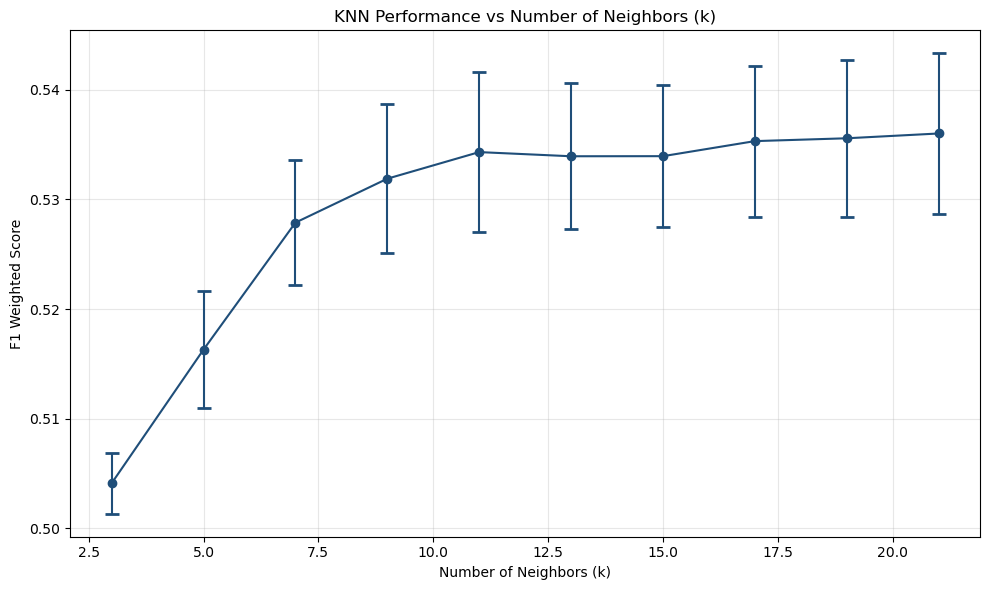

In [21]:
# ================================================================
# 14. KNN-SPECIFIC ANALYSIS: OPTIMAL K VALUE
# ================================================================

print(f"\n🔢 KNN-SPECIFIC ANALYSIS: K VALUE PERFORMANCE")
print("=" * 60)

# Analyze how different k values performed
k_performance = {}
for idx, row in results_df.iterrows():
    k = row['param_n_neighbors']
    score = row[primary_score_col]
    
    if k not in k_performance:
        k_performance[k] = []
    k_performance[k].append(score)

print("📊 Average performance by k value:")
k_sorted = sorted(k_performance.keys())
for k in k_sorted:
    scores = k_performance[k]
    avg_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"   k={k:2d}: {avg_score:.4f} ± {std_score:.4f}")

# Visualize k performance
plt.figure(figsize=(10, 6))
k_values = []
k_means = []
k_stds = []

for k in k_sorted:
    k_values.append(k)
    k_means.append(np.mean(k_performance[k]))
    k_stds.append(np.std(k_performance[k]))

plt.errorbar(k_values, k_means, yerr=k_stds, marker='o', capsize=5, capthick=2)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel(f'{recommended_scoring.replace("_", " ").title()} Score')
plt.title('KNN Performance vs Number of Neighbors (k)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# ================================================================
# 15. OPTIMIZED MODEL FOR PRODUCTION
# ================================================================

print(f"\n💾 OPTIMIZED MODEL FOR PRODUCTION")
print("=" * 60)

print("✅ Your optimized K-Nearest Neighbors model:")
print()
print("# Copy-paste this code to create your optimized model")
print("from sklearn.neighbors import KNeighborsClassifier")
print("from sklearn.preprocessing import StandardScaler")
print()
print("# Initialize scaler and model")
print("scaler = StandardScaler()")
print("optimized_knn = KNeighborsClassifier(")
for param, value in grid_search.best_params_.items():
    if isinstance(value, str):
        print(f"    {param}='{value}',")
    else:
        print(f"    {param}={value},")
print(")")
print()
print("# IMPORTANT: Always scale features for KNN!")
print("X_train_scaled = scaler.fit_transform(X_train)")
print("X_test_scaled = scaler.transform(X_test)")
print()
print("# Train and use the model")
print("optimized_knn.fit(X_train_scaled, y_train)")
print("y_pred = optimized_knn.predict(X_test_scaled)")


💾 OPTIMIZED MODEL FOR PRODUCTION
✅ Your optimized K-Nearest Neighbors model:

# Copy-paste this code to create your optimized model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Initialize scaler and model
scaler = StandardScaler()
optimized_knn = KNeighborsClassifier(
    algorithm='auto',
    metric='euclidean',
    n_neighbors=21,
    p=1,
    weights='uniform',
)

# IMPORTANT: Always scale features for KNN!
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and use the model
optimized_knn.fit(X_train_scaled, y_train)
y_pred = optimized_knn.predict(X_test_scaled)


In [23]:
# ================================================================
# 16. PERFORMANCE SUMMARY
# ================================================================

print(f"\n📈 PERFORMANCE SUMMARY")
print("=" * 60)

print(f"🎯 Optimization Results:")
print(f"   Best CV {recommended_scoring}: {grid_search.best_score_:.4f}")
print(f"   Test set accuracy:           {test_accuracy:.4f}")
print(f"   Test set F1-weighted:        {test_f1_weighted:.4f}")
print(f"   Test set F1-macro:           {test_f1_macro:.4f}")

print(f"\n⚙️  Best Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n⏱️  Optimization Details:")
print(f"   Approximate combinations tested: {total_combinations}")
print(f"   Cross-validation folds: 5")
print(f"   Runtime: {total_time/60:.1f} minutes")
print(f"   Primary scoring metric: {recommended_scoring}")

print(f"\n🔧 KNN-Specific Notes:")
print(f"   ⚡ Feature scaling: APPLIED (StandardScaler)")
print(f"   📏 Best distance metric: {grid_search.best_params_.get('metric', 'N/A')}")
print(f"   🔢 Optimal k value: {grid_search.best_params_.get('n_neighbors', 'N/A')}")
print(f"   ⚖️  Best weighting: {grid_search.best_params_.get('weights', 'N/A')}")

print(f"\n🎉 OPTIMIZATION COMPLETE!")
print("Your K-Nearest Neighbors model is now optimized and ready to use!")
print("⚠️  Remember: Always apply the same scaling to new data before prediction!")


📈 PERFORMANCE SUMMARY
🎯 Optimization Results:
   Best CV f1_weighted: 0.5453
   Test set accuracy:           0.5841
   Test set F1-weighted:        0.5445
   Test set F1-macro:           0.4370

⚙️  Best Hyperparameters:
   algorithm: auto
   metric: euclidean
   n_neighbors: 21
   p: 1
   weights: uniform

⏱️  Optimization Details:
   Approximate combinations tested: 242
   Cross-validation folds: 5
   Runtime: 23.0 minutes
   Primary scoring metric: f1_weighted

🔧 KNN-Specific Notes:
   ⚡ Feature scaling: APPLIED (StandardScaler)
   📏 Best distance metric: euclidean
   🔢 Optimal k value: 21
   ⚖️  Best weighting: uniform

🎉 OPTIMIZATION COMPLETE!
Your K-Nearest Neighbors model is now optimized and ready to use!
⚠️  Remember: Always apply the same scaling to new data before prediction!


In [24]:
# ================================================================
# 17. CREATE DIRECTORIES AND SAVE MODEL RESULTS
# ================================================================

import os
import joblib
import json
from datetime import datetime

print(f"\n💾 SAVING MODEL RESULTS")
print("=" * 60)

# Create directory structure
base_dir = "../Data"  # Go up one level from Notebooks to reach Data
model_metrics_dir = os.path.join(base_dir, "model_metrics")
models_dir = os.path.join(model_metrics_dir, "models")
metrics_dir = os.path.join(model_metrics_dir, "metrics")
reports_dir = os.path.join(model_metrics_dir, "reports")

# Create directories if they don't exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True) 
os.makedirs(reports_dir, exist_ok=True)

print(f"✅ Directory structure ready:")
print(f"   📁 {model_metrics_dir}")
print(f"   📁 {models_dir}")
print(f"   📁 {metrics_dir}")
print(f"   📁 {reports_dir}")


💾 SAVING MODEL RESULTS
✅ Directory structure ready:
   📁 ../Data\model_metrics
   📁 ../Data\model_metrics\models
   📁 ../Data\model_metrics\metrics
   📁 ../Data\model_metrics\reports


In [25]:
# ================================================================
# 18. SAVE THE TRAINED MODEL AND SCALER
# ================================================================

print(f"\n🤖 SAVING TRAINED MODEL AND SCALER")
print("=" * 60)

model_name = "knn_optimized"

# Save the trained model
model_path = os.path.join(models_dir, f"{model_name}.pkl")
joblib.dump(best_knn_model, model_path)

# Save the scaler (CRITICAL for KNN!)
scaler_path = os.path.join(models_dir, f"{model_name}_scaler.pkl")
joblib.dump(scaler, scaler_path)

print(f"✅ Model saved to: {model_path}")
print(f"✅ Scaler saved to: {scaler_path}")
print(f"📏 Model file size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")
print(f"📏 Scaler file size: {os.path.getsize(scaler_path) / 1024:.2f} KB")


🤖 SAVING TRAINED MODEL AND SCALER
✅ Model saved to: ../Data\model_metrics\models\knn_optimized.pkl
✅ Scaler saved to: ../Data\model_metrics\models\knn_optimized_scaler.pkl
📏 Model file size: 3.55 MB
📏 Scaler file size: 1.87 KB


In [ ]:
# ================================================================
# 19. SAVE PERFORMANCE METRICS
# ================================================================

print(f"\n📊 SAVING PERFORMANCE METRICS")
print("=" * 60)

# Helper function to convert numpy types to Python native types
def convert_numpy_types(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Prepare comprehensive metrics dictionary
model_metrics = {
    "model_info": {
        "model_name": "K-Nearest Neighbors Classifier",
        "optimization_method": "GridSearchCV",
        "primary_scoring_metric": recommended_scoring,
        "total_runtime_minutes": round(total_time/60, 2),
        "feature_scaling": "StandardScaler applied"
    },
    "dataset_info": {
        "training_samples": int(X_train_knn.shape[0]),
        "test_samples": int(X_test_knn.shape[0]),
        "n_features": int(X_train_knn.shape[1]),
        "n_classes": int(len(np.unique(y_train_knn))),
        "class_distribution": {str(k): int(v) for k, v in class_counts.items()}
    },
    "hyperparameters": {
        "best_params": convert_numpy_types(grid_search.best_params_),
        "approximate_combinations_tested": int(total_combinations),
        "cv_folds": cv_folds
    },
    "cross_validation_results": {
        "best_cv_score": float(grid_search.best_score_),
        "cv_scores_by_metric": {}
    },
    "test_set_performance": {
        "accuracy": float(test_accuracy),
        "f1_weighted": float(test_f1_weighted),
        "f1_macro": float(test_f1_macro)
    },
    "knn_specific_analysis": {
        "distance_metrics_performance": {
            metric: {
                "mean_score": float(np.mean(scores)),
                "std_score": float(np.std(scores))
            }
            for metric, scores in metric_performance.items()
        },
        "k_values_performance": {
            str(k): {
                "mean_score": float(np.mean(scores)),
                "std_score": float(np.std(scores))
            }
            for k, scores in k_performance.items()
        }
    }
}

# Add detailed CV results for all metrics
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name in scoring_metrics.keys():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        model_metrics["cross_validation_results"]["cv_scores_by_metric"][metric_name] = {
            "mean": float(cv_results[score_key][best_index]),
            "std": float(cv_results[std_key][best_index])
        }

# Convert the entire dictionary to ensure all numpy types are handled
model_metrics = convert_numpy_types(model_metrics)

# Save metrics as JSON
metrics_path = os.path.join(metrics_dir, f"{model_name}_metrics.json")
with open(metrics_path, 'w') as f:
    json.dump(model_metrics, f, indent=2)

print(f"✅ Metrics saved to: {metrics_path}")


📊 SAVING PERFORMANCE METRICS
✅ Metrics saved to: ../Data\model_metrics\metrics\knn_optimized_metrics.json


In [27]:
# ================================================================
# 20. SAVE CLASSIFICATION REPORT AND CONFUSION MATRIX
# ================================================================

print(f"\n📋 SAVING CLASSIFICATION REPORT")
print("=" * 60)

# Generate detailed classification report
from sklearn.metrics import classification_report

# Get classification report as dictionary
class_report_dict = classification_report(y_test_knn, y_pred_test, output_dict=True)

# Save classification report
report_path = os.path.join(reports_dir, f"{model_name}_classification_report.json")
with open(report_path, 'w') as f:
    json.dump(class_report_dict, f, indent=2)

print(f"✅ Classification report saved to: {report_path}")

# Save confusion matrix data
confusion_matrix_data = {
    "confusion_matrix": cm.tolist(),
    "class_labels": sorted(np.unique(y_train_knn).tolist()),
    "model_name": model_name
}

cm_path = os.path.join(metrics_dir, f"{model_name}_confusion_matrix.json")
with open(cm_path, 'w') as f:
    json.dump(confusion_matrix_data, f, indent=2)

print(f"✅ Confusion matrix saved to: {cm_path}")


📋 SAVING CLASSIFICATION REPORT
✅ Classification report saved to: ../Data\model_metrics\reports\knn_optimized_classification_report.json
✅ Confusion matrix saved to: ../Data\model_metrics\metrics\knn_optimized_confusion_matrix.json


In [28]:
# ================================================================
# 21. CREATE MODEL USAGE INSTRUCTIONS
# ================================================================

print(f"\n📖 SAVING MODEL USAGE INSTRUCTIONS")
print("=" * 60)

# Create instructions file
instructions = f"""
K-NEAREST NEIGHBORS MODEL USAGE INSTRUCTIONS
===========================================

Model Information:
- Model Name: {model_name}
- Model Type: K-Nearest Neighbors Classifier (Optimized)
- Model File: {model_path}
- Scaler File: {scaler_path}

⚠️  CRITICAL: KNN requires feature scaling! Always use the saved scaler.

LOADING THE MODEL:
-----------------
```python
import joblib
import pandas as pd
import numpy as np

# Load the trained model AND scaler
model = joblib.load('{model_path}')
scaler = joblib.load('{scaler_path}')

# IMPORTANT: Scale new data before prediction
X_new_scaled = scaler.transform(X_new)
predictions = model.predict(X_new_scaled)
prediction_probabilities = model.predict_proba(X_new_scaled)
```

BEST HYPERPARAMETERS:
-------------------
{json.dumps(grid_search.best_params_, indent=2)}

PERFORMANCE METRICS:
------------------
- Test Accuracy: {test_accuracy:.4f}
- Test F1-Weighted: {test_f1_weighted:.4f}
- Test F1-Macro: {test_f1_macro:.4f}
- Best CV Score ({recommended_scoring}): {grid_search.best_score_:.4f}

KNN-SPECIFIC INSIGHTS:
--------------------
- Optimal k (neighbors): {grid_search.best_params_.get('n_neighbors', 'N/A')}
- Best distance metric: {grid_search.best_params_.get('metric', 'N/A')}
- Weight strategy: {grid_search.best_params_.get('weights', 'N/A')}
- Feature scaling: StandardScaler applied

DISTANCE METRICS PERFORMANCE:
---------------------------
"""

for metric, scores in metric_performance.items():
    avg_score = np.mean(scores)
    instructions += f"{metric}: {avg_score:.4f}\n"

instructions += f"""

K VALUES PERFORMANCE:
-------------------
"""

for k in sorted(k_performance.keys()):
    avg_score = np.mean(k_performance[k])
    instructions += f"k={k}: {avg_score:.4f}\n"

instructions += f"""

FILES SAVED:
-----------
- Model: {model_path}
- Scaler: {scaler_path}
- Metrics: {metrics_path}
- Classification Report: {report_path}
- Usage Instructions: This file

NOTES:
-----
- This model was optimized using GridSearchCV
- Approximate combinations tested: {total_combinations}
- Cross-validation: 5-fold
- Optimization runtime: {total_time/60:.1f} minutes
- Primary scoring metric: {recommended_scoring}
- Feature scaling is MANDATORY for KNN - always use the saved scaler!

⚠️  REMEMBER: KNN is sensitive to feature scales. Always apply the same 
    StandardScaler transformation to new data before making predictions!
"""

instructions_path = os.path.join(model_metrics_dir, f"{model_name}_USAGE_INSTRUCTIONS.txt")
with open(instructions_path, 'w') as f:
    f.write(instructions)

print(f"✅ Usage instructions saved to: {instructions_path}")


📖 SAVING MODEL USAGE INSTRUCTIONS
✅ Usage instructions saved to: ../Data\model_metrics\knn_optimized_USAGE_INSTRUCTIONS.txt


In [29]:
# ================================================================
# 22. COMPLETE SAVE SUMMARY
# ================================================================

print(f"\n📁 COMPLETE SAVE SUMMARY")
print("=" * 60)

saved_files = [
    ("Trained Model", model_path),
    ("Feature Scaler", scaler_path),
    ("Metrics (JSON)", metrics_path),
    ("Classification Report", report_path),
    ("Confusion Matrix", cm_path),
    ("Usage Instructions", instructions_path)
]

print("✅ All files successfully saved:")
for file_type, file_path in saved_files:
    file_size = os.path.getsize(file_path)
    if file_size > 1024*1024:
        size_str = f"{file_size/(1024*1024):.2f} MB"
    elif file_size > 1024:
        size_str = f"{file_size/1024:.2f} KB"
    else:
        size_str = f"{file_size} bytes"
    
    print(f"   📄 {file_type:25s}: {os.path.basename(file_path):40s} ({size_str})")

print(f"\n🎉 KNN MODEL EXPORT COMPLETE!")
print(f"📂 All files are stored in: {model_metrics_dir}")
print(f"🔄 Model ID: {model_name}")

print(f"\n💡 To load this model later:")
print(f"   model = joblib.load('{model_path}')")
print(f"   scaler = joblib.load('{scaler_path}')")
print(f"   ⚠️  Don't forget to scale your features!")

print(f"\n🔍 KNN vs Random Forest Quick Comparison:")
print(f"   📊 KNN is instance-based (lazy learning)")
print(f"   📊 RF builds decision trees (eager learning)")
print(f"   ⚡ KNN requires feature scaling, RF doesn't")
print(f"   🎯 KNN good for local patterns, RF for global patterns")
print(f"   ⏱️  KNN slower predictions, RF faster predictions")


📁 COMPLETE SAVE SUMMARY
✅ All files successfully saved:
   📄 Trained Model            : knn_optimized.pkl                        (3.55 MB)
   📄 Feature Scaler           : knn_optimized_scaler.pkl                 (1.87 KB)
   📄 Metrics (JSON)           : knn_optimized_metrics.json               (3.05 KB)
   📄 Classification Report    : knn_optimized_classification_report.json (802 bytes)
   📄 Confusion Matrix         : knn_optimized_confusion_matrix.json      (268 bytes)
   📄 Usage Instructions       : knn_optimized_USAGE_INSTRUCTIONS.txt     (2.44 KB)

🎉 KNN MODEL EXPORT COMPLETE!
📂 All files are stored in: ../Data\model_metrics
🔄 Model ID: knn_optimized

💡 To load this model later:
   model = joblib.load('../Data\model_metrics\models\knn_optimized.pkl')
   scaler = joblib.load('../Data\model_metrics\models\knn_optimized_scaler.pkl')
   ⚠️  Don't forget to scale your features!

🔍 KNN vs Random Forest Quick Comparison:
   📊 KNN is instance-based (lazy learning)
   📊 RF builds decision 